In [1]:
import torch 
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms

import copy
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x

In [3]:
def gram_matrix(x):
    a, b, c, d = x.size()  # a=batch size(=1)
                            # b=number of feature maps
                            # (c,d)=dimensions of a f. map (N=c*d)

    features = x.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G/(a * b * c * d)

In [4]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        self.loss = F.mse_loss(gram_matrix(x), self.target)
        return x

In [5]:
device = 'cuda:0'

In [6]:
cnn = torchvision.models.vgg19(pretrained=True).features.to(device).eval()

In [12]:
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [16]:
ToTensor = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor()  
])

In [17]:
content_img = ToTensor(Image.open('content.jpg')).unsqueeze(0).cuda()
style_img = ToTensor(Image.open('style.jpg')).unsqueeze(0).cuda()
input_img = content_img.clone()

In [18]:
def tensor_to_np(tensor):
    return tensor.permute(0,2,3,1).squeeze(0).detach().cpu().numpy() 

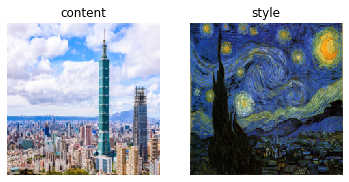

In [19]:
plt.subplot(1,2,1)
plt.title('content')
plt.axis('off')
plt.imshow(tensor_to_np(content_img))
plt.subplot(1,2,2)
plt.title('style')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))

In [20]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..


c:\users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
c:\users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Optimizing..
run [50]:
Style Loss : 341.467285 Content Loss: 23.011436

run [100]:
Style Loss : 144.542023 Content Loss: 27.078028

run [150]:
Style Loss : 70.903831 Content Loss: 27.762486

run [200]:
Style Loss : 37.566372 Content Loss: 25.085533

run [250]:
Style Loss : 22.400276 Content Loss: 22.537945

run [300]:
Style Loss : 14.629819 Content Loss: 20.676605



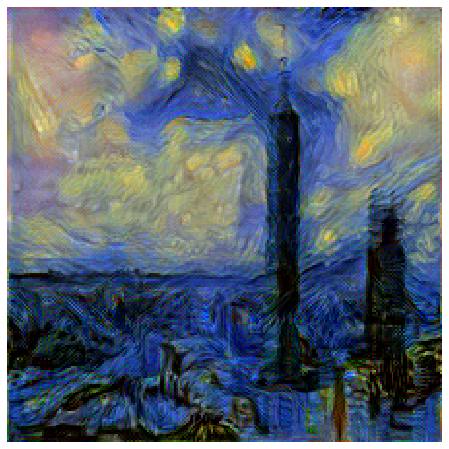

In [22]:
output_post = output.permute(0,2,3,1).squeeze(0).detach().cpu().numpy() 

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(output_post)